In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.optimize import check_grad 
from sklearn.linear_model import LogisticRegression
np.set_printoptions(precision=3)

## Least squares without strong convexity

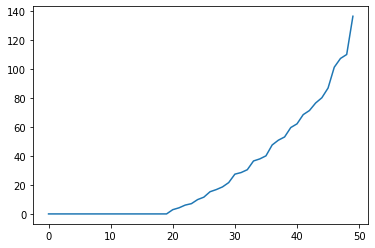

In [2]:
np.random.seed(0)
n_samples, n_features = 30, 50
b = np.random.randn(n_samples)
A = np.random.randn(n_samples, n_features)

eigvals = np.linalg.eigvalsh(A.T @ A)
plt.plot(eigvals)

In [3]:
max_iter = 1000
L = norm(A, ord=2) ** 2
x = np.zeros(A.shape[1])
objs = []
for it in range(max_iter):
    x -= 1. / L * A.T @ (A @ x - b)
    objs.append(0.5 * norm(A @ x - b) ** 2)

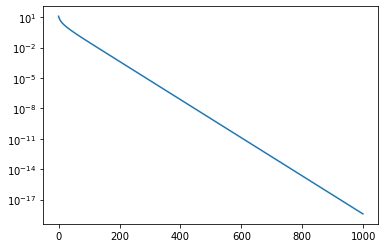

In [4]:
plt.semilogy(objs)

Why do observe a linear rate eventhough the objective is not strongly convex? 

## Logistic regression

For binary labels $b_i \in \{-1, 1\}$ and observations $a_i \in \mathbb{R}^d$, the \emph{logistic regression} estimator is defined as the solution of:

$$ \min \sum_{i=1}^n \log (1 + \exp(- b_i a_i^\top x)) $$

Let's inverstigate gradient descent behavior on this objective function, on toy data.

In [5]:
np.random.seed(0)
n_samples, n_features = 50, 50
b = np.sign(np.random.randn(n_samples))
A = np.random.randn(n_samples, n_features)

# this is a subtle hack to avoid a very interesting divergence phenomenon
A = np.vstack([A, A[-1, :]])
b = np.hstack([b, - b[-1:]])

eigvals = np.linalg.eigvalsh(A.T @ A)
print(eigvals)

[3.326e-02 2.434e-01 4.430e-01 7.525e-01 9.840e-01 1.091e+00 1.763e+00
 2.690e+00 3.671e+00 4.725e+00 5.843e+00 6.401e+00 7.723e+00 9.114e+00
 1.043e+01 1.344e+01 1.573e+01 1.662e+01 1.996e+01 2.022e+01 2.119e+01
 2.272e+01 2.515e+01 2.834e+01 2.965e+01 3.334e+01 3.623e+01 3.799e+01
 4.246e+01 4.394e+01 4.875e+01 5.301e+01 5.602e+01 5.984e+01 6.517e+01
 7.322e+01 7.583e+01 7.912e+01 8.534e+01 8.883e+01 9.583e+01 9.955e+01
 1.093e+02 1.117e+02 1.183e+02 1.297e+02 1.391e+02 1.411e+02 1.553e+02
 1.614e+02]


The objective value and its gradient can be computed explicitely:  

In [6]:
def logistic_loss(x):
    return np.log(1. + np.exp(-b * (A @ x))).sum()

def grad_logistic_loss(x):
    return A.T @ (- b / (1. + np.exp(b * (A @ x))))

We check that our formula for the gradient is close to the one that `scipy` can compute with finite difference method:

In [7]:
check_grad(logistic_loss, grad_logistic_loss, np.random.randn(n_features)) 
# norm of difference should be small 

1.335817035385223e-05

The objective is smooth, with Lipschitz constant given by (see exercise sheet):

In [8]:
L = np.linalg.norm(A, ord=2) ** 2 / 4.

In [9]:
# GD algorithm:
def GD_logreg(x0, stepsize=1/L, max_iter=20):
    x = x0.copy()
    objs = []
    for it in range(max_iter):
        x -= stepsize * grad_logistic_loss(x)
        objs.append(logistic_loss(x))

    return x, objs

In [10]:
x, objs = GD_logreg(np.zeros(n_features), 1/L, 5000)

In [11]:
x

array([ 1.581,  0.064,  3.915,  0.478,  0.256,  1.116, -1.333, -0.791,
       -3.275, -1.179,  1.033,  0.997,  0.44 ,  1.157,  3.413,  0.896,
        0.425,  2.767,  2.641, -0.976,  0.633, -0.925,  3.316,  0.777,
        2.423, -1.666, -3.917,  2.584, -1.303, -0.148, -1.441, -2.275,
       -1.571,  0.745,  0.116, -0.612,  1.221, -1.099,  1.296,  1.666,
       -2.724,  3.101,  0.921,  1.443, -1.882,  1.44 ,  0.506,  0.012,
        0.842,  1.418])

In [12]:
clf = LogisticRegression(penalty='none', fit_intercept=False, tol=0, solver='lbfgs').fit(A, b)
clf.coef_

array([[  5.053,   0.72 ,  16.585,   1.687,   0.825,   4.078,  -6.874,
         -2.45 , -14.037,  -5.386,   4.261,   4.626,   1.108,   2.952,
         11.915,   5.2  ,   0.785,  11.911,  10.338,  -4.027,   3.014,
         -4.086,  12.308,   3.342,   8.974,  -7.814, -16.814,   9.578,
         -5.435,  -0.668,  -4.331,  -8.726,  -5.962,   2.796,   0.345,
         -1.572,   5.464,  -4.861,   5.823,   6.099, -11.459,  12.18 ,
          3.631,   4.928,  -6.876,   7.268,   1.611,  -0.648,   3.923,
          5.426]])

In [13]:
logistic_loss(x)

1.4118908289601864

In [14]:
p_star = logistic_loss(clf.coef_[0])
p_star

1.3862943629485234

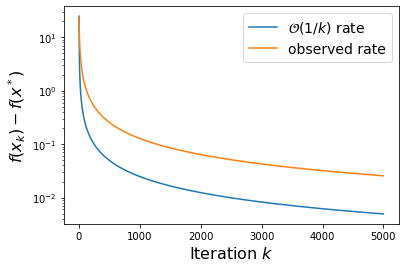

In [15]:
it = np.arange(1, len(objs) + 1)
plt.semilogy(it, objs[0] / it, label="$\mathcal{O}(1 / k)$ rate")
plt.semilogy(objs - p_star, label='observed rate')
plt.xlabel("Iteration $k$", fontsize=16)
plt.legend(fontsize=14)
plt.ylabel("$f(x_k) - f(x^*)$", fontsize=16);

## GD on strongly convex Least Squares: another puzzle

In [16]:
n_samples, n_features = 500, 500
A = np.random.randn(n_samples, n_features)
b = np.random.randn(n_samples)

L = np.linalg.norm(A, ord=2) ** 2

In [17]:
max_iter = 500
x0 = np.ones(n_features)
x = x0.copy()
objs = []
for it in range(max_iter):
    if it % 100 == 0:
        print(f'Iter {it}')
    x = x - 1. / L * A.T @ (A @ x - b)
    objs.append(norm(A @ x - b) ** 2 / 2)

Iter 0
Iter 100
Iter 200
Iter 300
Iter 400


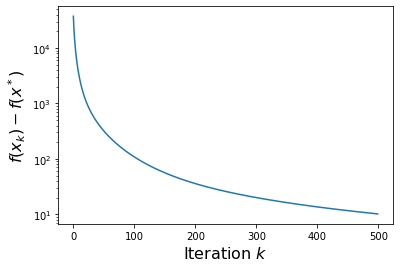

In [18]:
plt.semilogy(objs)
plt.xlabel("Iteration $k$", fontsize=16)
plt.ylabel("$f(x_k) - f(x^*)$", fontsize=16);

In [19]:
eigvals = np.linalg.eigvalsh(A.T @ A)

In [20]:
kappa = eigvals[-1] / eigvals[0]
print(kappa)

36379523.80165397


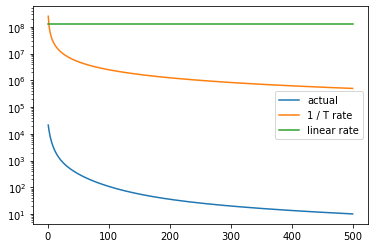

In [21]:
x_star = np.linalg.solve(A, b)
it = np.arange(1, max_iter)
plt.semilogy(it, objs[1:], label='actual')
plt.semilogy(it, 2 * L * norm(x0 - x_star)  ** 2 / it, label='1 / T rate')
plt.semilogy(it, L * norm(x0 - x_star) ** 2 * np.exp(- it / kappa), label='linear rate')
plt.legend()